<a href="https://colab.research.google.com/github/diperezbgit/IA-FUNDAMENTALS/blob/main/TAREA_2/TAREA_2_HC_SA_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Vehicle Routing Problem (VRP) para Optimización de Rutas en Conexiones Eléctricas
### Se tiene "n" cuadrillas (camiones) encargadas de atender un conjunto de conexiones eléctricas distribuidas en diferentes distritos. El objetivo es optimizar el tiempo total de atención mediante la determinación del orden óptimo en que la cuadrillas deben visitar cada punto de conexión.




# Carga y visualización de imagen GIS de asignación ordenes de trabajo


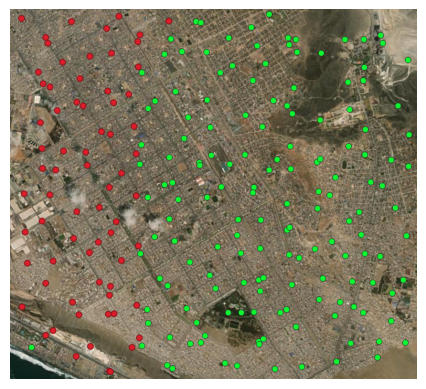

In [42]:
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO

url = 'https://raw.githubusercontent.com/diperezbgit/IA-FUNDAMENTALS/main/TAREA_2/cnx_gis.png'

response = requests.get(url)
img = Image.open(BytesIO(response.content))

plt.imshow(img)
plt.axis('off')  # Quita los ejes
plt.show()


# Importamos el archivo de ubicación de ordenes de **trabajo**



In [43]:
import pandas as pd
import numpy as np
#  obtenemos al archivo que contiene la informacion sobre las conexiones y ditancias entre ellas
path = r"https://raw.githubusercontent.com/diperezbgit/IA-FUNDAMENTALS/refs/heads/main/TAREA_2/cnx_cuadri02.csv"
df_long = pd.read_csv(path)
# par las pruebas usamos solo 70 puntos
df_reduced = df_long.iloc[:70, :70]
df_reduced


,id,y,x
0,0,8.651913e+06,286690.715164
1,1,8.651592e+06,287093.287133
2,2,8.651016e+06,286976.587931
3,3,8.651502e+06,287134.107559
4,4,8.650819e+06,287052.401729
...,...,...,...
65,65,8.646584e+06,288652.465776
66,66,8.646433e+06,288531.950857
67,67,8.646025e+06,288170.717954
68,68,8.651641e+06,288669.414069


# Función plot

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

def plot_tsp_style_2(nodes, route, title, ax, time=None, fitness=None):
    """
    Soporta una ruta única (lista de nodos) o múltiples rutas (lista de listas).
    Leyenda en la esquina inferior derecha. Tiempo y fitness en la inferior izquierda.
    """
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.grid(True)

    x, y = zip(*nodes)
    ax.scatter(x, y, c='black', s=50, zorder=2)
    ax.scatter(*nodes[0], c='yellow', s=100, edgecolors='black', label='Depósito', zorder=3)

    colors = ['blue', 'green', 'orange', 'red', 'purple', 'brown']

    if isinstance(route[0], list):  # múltiples rutas (multivehículo)
        for idx, subroute in enumerate(route):
            if not subroute:
                continue
            full_route = [0] + subroute + [0]
            xs, ys = zip(*[nodes[i] for i in full_route])
            ax.plot(xs, ys, marker='o', color=colors[idx % len(colors)], label=f'Vehículo {idx+1}', zorder=1)
    else:  # ruta única
        full_route = list(route) + [route[0]]
        xs, ys = zip(*[nodes[i] for i in full_route])
        ax.plot(xs, ys, marker='o', color='blue', label='Ruta TSP', zorder=1)

    # Leyenda en esquina inferior derecha
    ax.legend(loc='lower right')

    # Texto de tiempo y fitness en esquina inferior izquierda
    if time is not None or fitness is not None:
        texto = ""
        if time is not None:
            texto += f"Time: {time:.2f} s\n"
        if fitness is not None:
            texto += f"Fitness: {fitness:.2f}"
        ax.text(0.05, 0.05, texto.strip(),
                transform=ax.transAxes,
                fontsize=10,
                verticalalignment='bottom',
                horizontalalignment='left',
                bbox=dict(facecolor='white', alpha=0.8))




# Hill Climbing multiple

In [45]:
import numpy as np, random, copy

def euclidean(p1, p2): return np.linalg.norm(np.array(p1) - np.array(p2))

def build_TSP(positions):
    return [[euclidean(p1, p2) for p2 in positions] for p1 in positions]

def fitness(routes, TSP):
    return sum(
        TSP[0][r[0]] + sum(TSP[r[i]][r[i+1]] for i in range(len(r)-1)) + TSP[r[-1]][0]
        for r in routes if r
    )

def initial_solution(n_customers, n_vehicles):
    clients = list(range(1, n_customers))  # excluir el depósito
    random.shuffle(clients)
    avg = len(clients) // n_vehicles
    return [clients[i*avg:(i+1)*avg] for i in range(n_vehicles-1)] + [clients[(n_vehicles-1)*avg:]]

def get_neighbors(routes):
    neighbors = []
    for i in range(len(routes)):
        for j in range(i, len(routes)):
            for a in range(len(routes[i])):
                for b in range(len(routes[j])):
                    if i == j and a == b: continue
                    new = copy.deepcopy(routes)
                    new[i][a], new[j][b] = new[j][b], new[i][a]
                    neighbors.append(new)
    return neighbors

def hill_climbing_multi(positions, n_vehicles):
    TSP = build_TSP(positions)
    current = initial_solution(len(positions), n_vehicles)
    init = copy.deepcopy(current)

    while True:
        neighbors = get_neighbors(current)
        best = min(neighbors, key=lambda r: fitness(r, TSP))
        if fitness(best, TSP) < fitness(current, TSP):
            current = best
        else:
            return current, fitness(current, TSP), init, fitness(init, TSP)


# Simulated Annealing multiple

In [46]:
import numpy as np, random, copy

def euclidean(p1, p2): return np.linalg.norm(np.array(p1) - np.array(p2))

def build_TSP(positions):
    return [[euclidean(p1, p2) for p2 in positions] for p1 in positions]

def fitness(routes, TSP):
    return sum(
        TSP[0][r[0]] + sum(TSP[r[i]][r[i+1]] for i in range(len(r)-1)) + TSP[r[-1]][0]
        for r in routes if r
    )

def initial_solution(n_customers, n_vehicles):
    clients = list(range(1, n_customers))  # sin el depósito
    random.shuffle(clients)
    avg = len(clients) // n_vehicles
    return [clients[i*avg:(i+1)*avg] for i in range(n_vehicles-1)] + [clients[(n_vehicles-1)*avg:]]

def random_neighbor(sol):
    new = copy.deepcopy(sol)
    if len(sol) == 1:
        # Un solo vehículo: permutar dentro de la única ruta
        if len(sol[0]) >= 2:
            i, j = random.sample(range(len(sol[0])), 2)
            new[0][i], new[0][j] = new[0][j], new[0][i]
    else:
        # Múltiples vehículos: intercambiar clientes entre dos rutas
        r1, r2 = random.sample(range(len(sol)), 2)
        if sol[r1] and sol[r2]:
            i, j = random.randint(0, len(sol[r1])-1), random.randint(0, len(sol[r2])-1)
            new[r1][i], new[r2][j] = new[r2][j], new[r1][i]
    return new

def accept(delta, T):
    return delta < 0 or random.random() < np.exp(-delta / T)

def simulated_annealing_multi(positions, n_vehicles, T_max, T_min, cooling_rate):
    TSP = build_TSP(positions)
    x = initial_solution(len(positions), n_vehicles)
    E = fitness(x, TSP)
    sol_init = copy.deepcopy(x)

    while T_max > T_min:
        x_new = random_neighbor(x)
        E_new = fitness(x_new, TSP)
        if accept(E_new - E, T_max):
            x, E = x_new, E_new
        T_max *= cooling_rate

    return x, E, sol_init, fitness(sol_init, TSP)


# Ejecución de algoritmos

In [47]:
import time

#N = len(df_reduced) # cantidad de conexiones
positions = df_reduced[['x', 'y']].values
n_vehicles=2

inicio_hc = time.time()
sol_hc, final_cost_hc, init_sol_hc, init_cost_hc = hill_climbing_multi(positions, n_vehicles)
fin_hc = time.time()

print("Inicial:", init_sol_hc, "\nCosto inicial:", init_cost_hc)
print("Final:  ", sol_hc, "\nCosto final:  ", final_cost_hc)

T_max = 1000
T_min = 0.000001
cooling_rate = 0.9999

inicio_sa = time.time()
sol_sa, final_cost_sa, init_sol_sa, init_cost_sa = simulated_annealing_multi(positions, n_vehicles,T_max,T_min, cooling_rate)
fin_sa = time.time()

print("Inicial:", init_sol_sa, "\nCosto inicial:", init_cost_sa)
print("Final:  ", sol_sa, "\nCosto final:  ", final_cost_sa)

Inicial: [[24, 42, 14, 57, 5, 28, 21, 34, 32, 64, 1, 25, 38, 19, 51, 44, 55, 53, 10, 52, 45, 30, 40, 49, 33, 63, 23, 69, 15, 31, 2, 4, 54, 60], [65, 48, 66, 59, 46, 9, 11, 41, 16, 37, 36, 20, 62, 7, 35, 29, 6, 8, 27, 67, 58, 13, 61, 12, 68, 26, 3, 56, 47, 17, 50, 22, 18, 43, 39]] 
Costo inicial: 175967.71839714661
Final:   [[9, 13, 14, 27, 29, 45, 44, 64, 62, 43, 26, 12, 25, 22, 36, 18, 35, 34, 55, 53, 69, 47, 30, 49, 33, 51, 50, 48, 68, 31, 16, 3, 1, 15], [5, 6, 41, 63, 61, 40, 42, 24, 39, 37, 38, 20, 21, 7, 23, 8, 10, 11, 28, 46, 67, 66, 65, 59, 58, 54, 52, 32, 2, 4, 17, 19, 60, 57, 56]] 
Costo final:   48386.22506186018
Inicial: [[38, 5, 24, 2, 41, 4, 17, 67, 39, 53, 8, 59, 55, 35, 3, 54, 6, 7, 60, 46, 1, 10, 48, 56, 12, 9, 18, 31, 30, 65, 13, 28, 69, 66], [63, 26, 64, 29, 22, 15, 50, 58, 45, 34, 44, 33, 37, 21, 20, 25, 27, 51, 42, 16, 43, 14, 47, 61, 40, 57, 23, 11, 62, 52, 68, 36, 19, 32, 49]] 
Costo inicial: 162717.72760160765
Final:   [[19, 39, 63, 14, 27, 45, 12, 11, 13, 25, 24

# Resultados

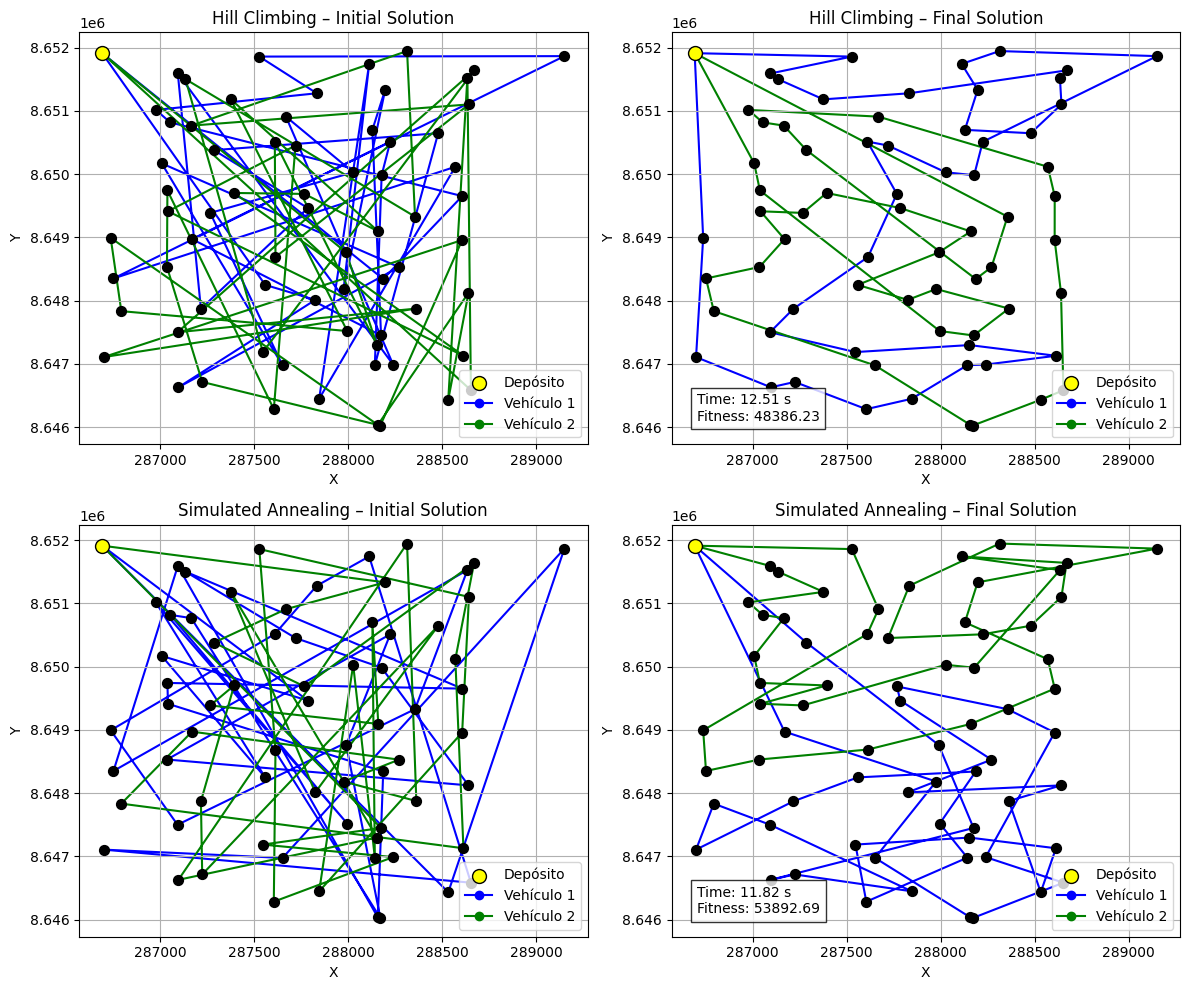

In [48]:
route1 = init_sol_hc
dist1 = init_sol_hc
route2 = sol_hc
dist2 = final_cost_hc

route3 = init_sol_sa
dist3 = init_sol_sa
route4 = sol_sa
dist4 = final_cost_sa

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

plot_tsp_style_2(positions, route1, 'Hill Climbing – Initial Solution', axs[0][0])
plot_tsp_style_2(positions, route2, 'Hill Climbing – Final Solution', axs[0][1], time=fin_hc - inicio_hc, fitness=dist2)
plot_tsp_style_2(positions, route3, 'Simulated Annealing – Initial Solution', axs[1][0])
plot_tsp_style_2(positions, route4, 'Simulated Annealing – Final Solution', axs[1][1], time=fin_sa - inicio_sa, fitness=dist4)

plt.tight_layout()
plt.show()